### Helpers

In [6]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import string

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

I will use the same functions from EDA notebook - I want to clean the data again before modeling

In [ ]:
# Functions for cleaning

In [7]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','\'em', 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh','jd', 'je','wow','ii', 'iii', 'it','ima',
                   'imma','jr', 'js','y\'all','y\'']

In [ ]:
#Checking my list of stopwords
stopwords_list

## Getting dataframes

In [10]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [11]:
print(df.shape) #(27109, 23)
df.head()

(27109, 23)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboy, old...",290,1990-00s


In [12]:
#drop some columns before re-cleaning the data
df = df.drop(columns=['Album','duration_ms','tokens','tokens_lemma'])

In [13]:
df.head()

,Artist,Title,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s
1,Machine Gun Kelly,Candy,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s
2,Big Pun,You Ain’t a Killer,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s
3,Das EFX,Buck-Buck,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s


## Tokenize

In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [15]:
# Convert to list
data = df.Cleaned_lyrics.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['for', 'years', 'have', 'been', 'waitin', 'and', 'hesitatin', 'to', 'make', 'rap', 'record', 'that', 'had', 'the', 'pace', 'of', 'slow', 'song', 'quiet', 'storm', 'chillin', 'while', 'the', 'fire', 'is', 'warm', 'you', 'and', 'your', 'girl', 'with', 'this', 'record', 'on', 'your', 'radio', 'or', 'stereo', 'dont', 'know', 'love', 'you', 'so', 'is', 'what', 'youll', 'be', 'sayin', 'while', 'this', 'records', 'playin', 'you', 'reminscin', 'and', 'kissin', 'your', 'girl', 'relax', 'lay', 'back', 'unwind', 'because', 'now', 'its', 'time', 'to', 'chill', 'setting', 'the', 'mood', 'by', 'the', 'use', 'of', 'this', 'groove', 'is', 'an', 'ingenious', 'perceptive', 'brilliant', 'very', 'clever', 'move', 'because', 'the', 'bass', 'line', 'combined', 'with', 'the', 'fresh', 'rhyme', 'at', 'slow', 'tempo', 'entices', 'passion', 'to', 'grow', 'but', 'if', 'its', 'not', 'passion', 'for', 'which', 'you', 'search', 'then', 'use', 'the', 'song', 'as', 'massage', 'after', 'hard', 'days', 'work', 'and',

In [ ]:
len(data_words)

## Build Bigram, Trigram Models and Lemmatize

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once

In [18]:
#Function to process lyrics
def process_words(texts, stop_words=stopwords_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [19]:
data_ready = process_words(data_words)  # processed Text Data!

In [20]:
data_ready[:1]

[['year',
  'make',
  'rap',
  'record',
  'pace',
  'slow',
  'song',
  'quiet_storm',
  'chillin',
  'fire',
  'warm',
  'girl',
  'record',
  'know',
  'love',
  'sayin',
  'playin',
  'relax',
  'lie',
  'back',
  'unwind',
  'time',
  'chill',
  'set',
  'mood',
  'use',
  'groove',
  'ingenious',
  'perceptive',
  'brilliant',
  'clever',
  'bass',
  'line',
  'combine',
  'fresh',
  'rhyme',
  'slow',
  'tempo',
  'entice',
  'passion',
  'grow',
  'passion',
  'search',
  'use',
  'song',
  'massage',
  'hard',
  'day',
  'work',
  'true',
  'music',
  'calm',
  'savage',
  'beast',
  'play',
  'cut',
  'jungle',
  'put',
  'lion',
  'sleep',
  'take',
  'deep',
  'breath',
  'footwear',
  'put',
  'tape',
  'record',
  'beware',
  'caution_warning',
  'decision',
  'nothing',
  'strong',
  'buy',
  'prescription',
  'soothe',
  'somewhat',
  'hypnotic',
  'rhythmic',
  'anesthetic',
  'practically',
  'narcotic',
  'want',
  'get',
  'come',
  'widdit',
  'push',
  'hit',
  'o

## Build the Topic Model

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [24]:
#check the topic
for topic in lda_model.print_topics():
    print(topic)
# print(lda_model.print_topics())

(0, '0.077*"get" + 0.037*"money" + 0.012*"high" + 0.011*"big" + 0.011*"pull" + 0.010*"go" + 0.010*"pop" + 0.009*"make" + 0.009*"tryna" + 0.009*"top"')
(1, '0.059*"get" + 0.039*"nigga" + 0.032*"shit" + 0.032*"fuck" + 0.027*"bitch" + 0.023*"know" + 0.014*"hit" + 0.013*"go" + 0.013*"come" + 0.012*"say"')
(2, '0.036*"go" + 0.034*"know" + 0.028*"get" + 0.023*"say" + 0.019*"let" + 0.018*"see" + 0.018*"time" + 0.017*"love" + 0.017*"never" + 0.017*"make"')
(3, '0.014*"man" + 0.011*"make" + 0.010*"come" + 0.008*"get" + 0.007*"try" + 0.007*"start" + 0.006*"better" + 0.006*"beat" + 0.006*"flow" + 0.006*"game"')
(4, '0.020*"life" + 0.018*"die" + 0.013*"kill" + 0.012*"black" + 0.009*"soul" + 0.009*"run" + 0.009*"see" + 0.008*"people" + 0.008*"eye" + 0.008*"world"')


## Dominant topic and its percentage contribution in each lyric

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5166,"man, make, come, get, try, start, better, beat...","[year, make, rap, record, pace, slow, song, qu..."
1,1,0.0,0.2852,"get, money, high, big, pull, go, pop, make, tr...","[big, know, fuck, go, know, keep, candy, need,..."
2,2,3.0,0.3870,"man, make, come, get, try, start, better, beat...","[harsh, reality, life, take, toll, even, forsa..."
3,3,3.0,0.5048,"man, make, come, get, try, start, better, beat...","[give, shoutout, chorus, give, buckbuck, front..."
4,4,3.0,0.7541,"man, make, come, get, try, start, better, beat...","[beat, beat, beat, go, homeboy, old, school, w..."
5,5,1.0,0.4848,"get, nigga, shit, fuck, bitch, know, hit, go, ...","[shit, switch, cd, throw, whip, window, clog, ..."
6,6,3.0,0.4790,"man, make, come, get, try, start, better, beat...","[day, time, hold, head, lose, mind, sometimes,..."
7,7,2.0,0.4209,"go, know, get, say, let, see, time, love, neve...","[sunshine, fool, say, never, rain, tell, true,..."
8,8,2.0,0.5065,"go, know, get, say, let, see, time, love, neve...","[kid, corner, fuck, go, fuck, go, look, give, ..."
9,9,2.0,0.4685,"go, know, get, say, let, see, time, love, neve...","[go, flame, night, burn, brighter, go, flame, ..."


In [27]:
df_dominant_topic.shape

(27109, 5)

In [28]:
#combine everything
df_dominant_topic_df = pd.concat([df,df_dominant_topic], axis=1)

## The most representative lyric for each topic

In [31]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8663,"get, money, high, big, pull, go, pop, make, tryna, top","[get, molly, get, white, get, molly, get, white, damn, night, get, molly, get, white, get, molly..."
1,1.0,0.9848,"get, nigga, shit, fuck, bitch, know, hit, go, come, say","[know, want, give, give, know, want, give, give, give, give, give, give, give, give, give, give,..."
2,2.0,0.9938,"go, know, get, say, let, see, time, love, never, make","[give, ill, give, know, want, know, get, baby, give, ill, give, long, want, know, get, baby, giv..."
3,3.0,0.9555,"man, make, come, get, try, start, better, beat, flow, game","[bagagoombagi, chant, begin, hear, stay, focused, focus, mind, bagagoombagi, repeat, time, vario..."
4,4.0,0.7184,"life, die, kill, black, soul, run, see, people, eye, world","[know, find, know, find, taime, beaucoup, drole, longer, deny, blind, glory_glory, blind, hmhmm,..."


## Frequency Distribution of Word Counts in Lyrics

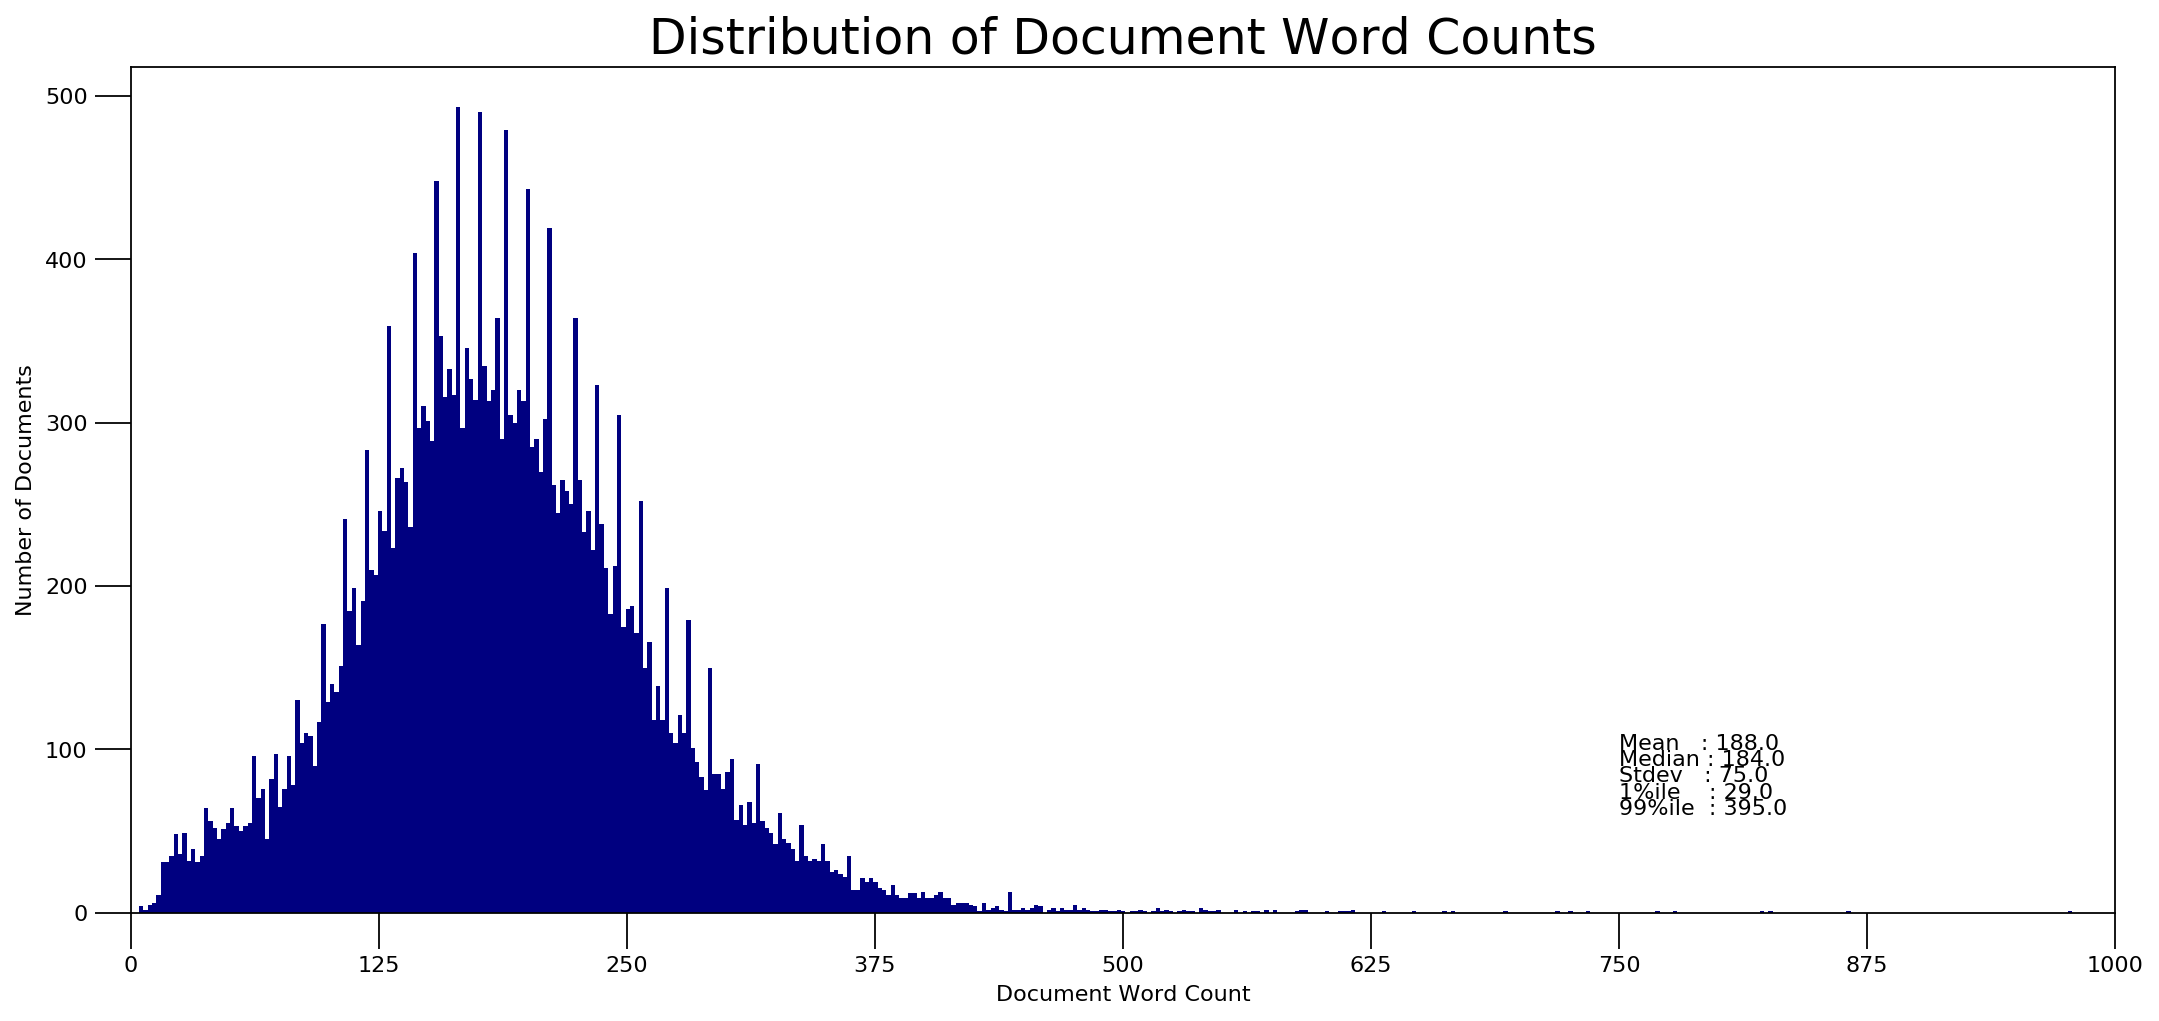

In [36]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

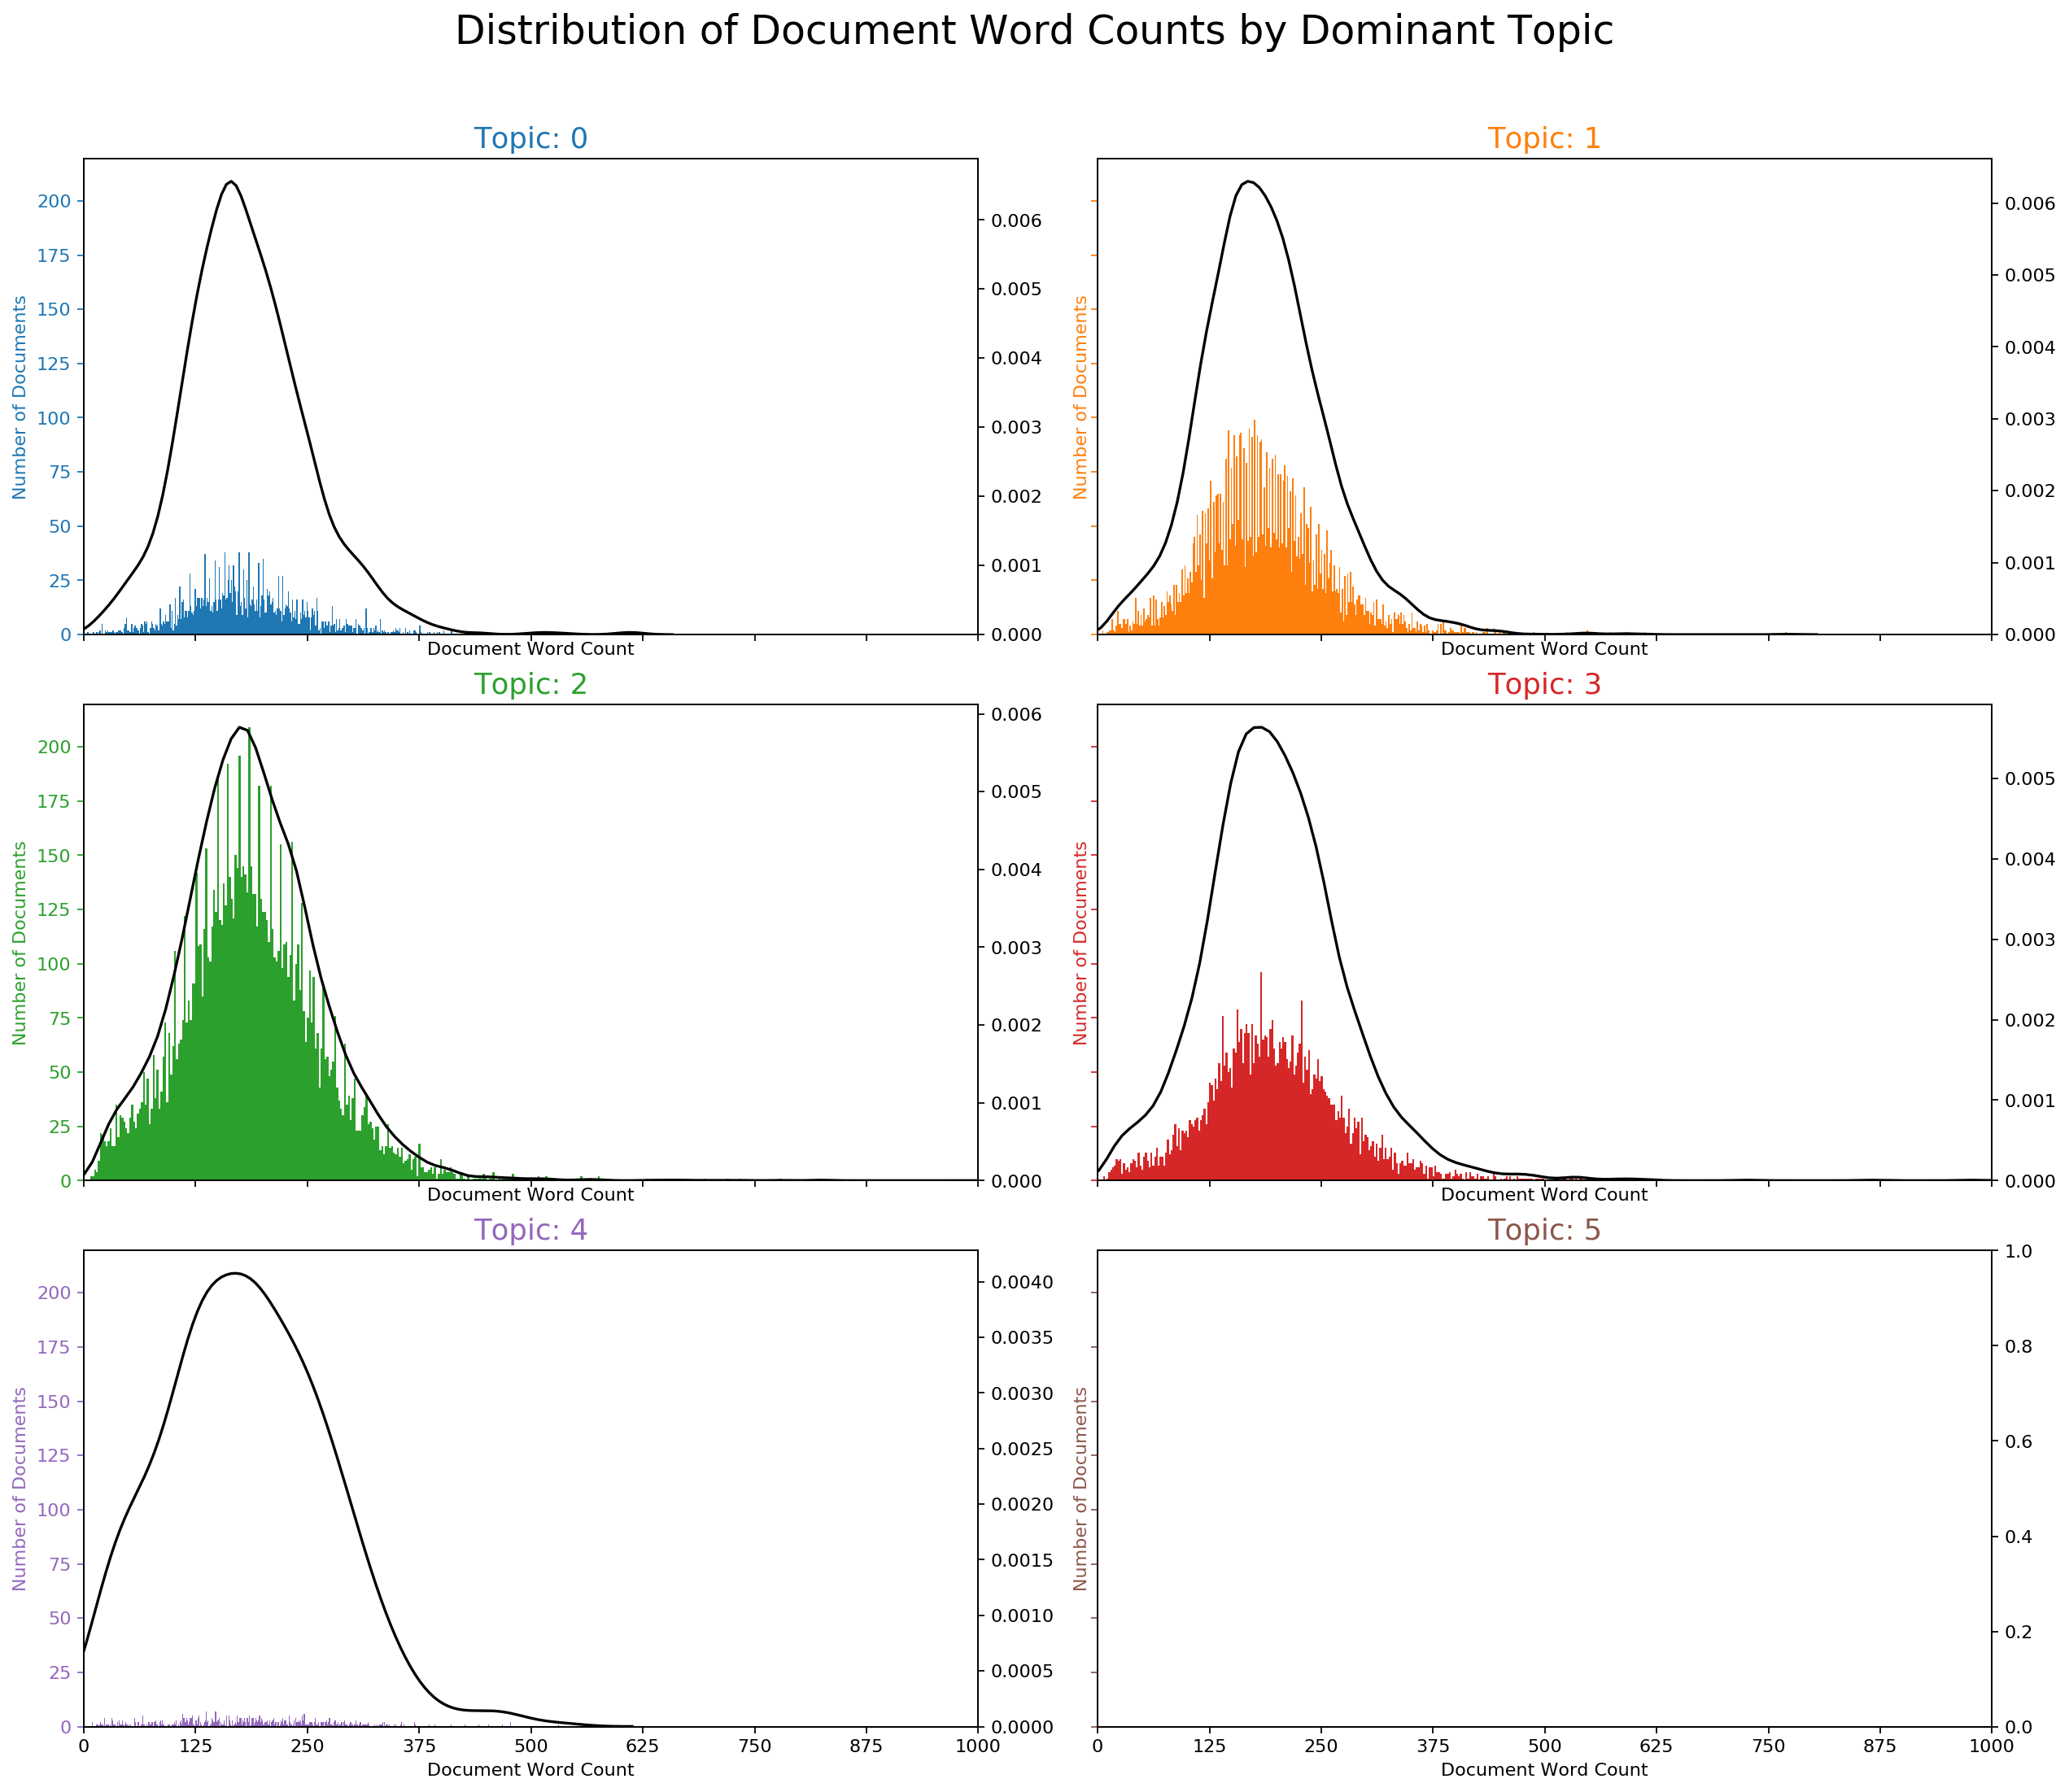

In [38]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 500, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [39]:
# 4 topic might be ok

## Word Clouds of Top 25 Keywords in Each Topic

IndexError: list index out of range

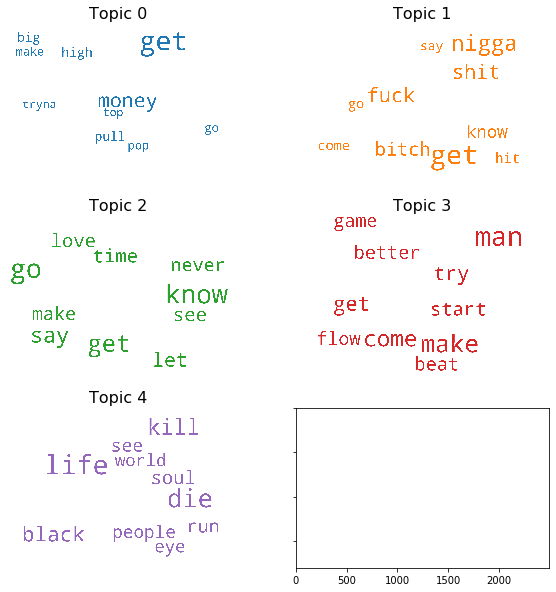

In [43]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_list,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=25,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

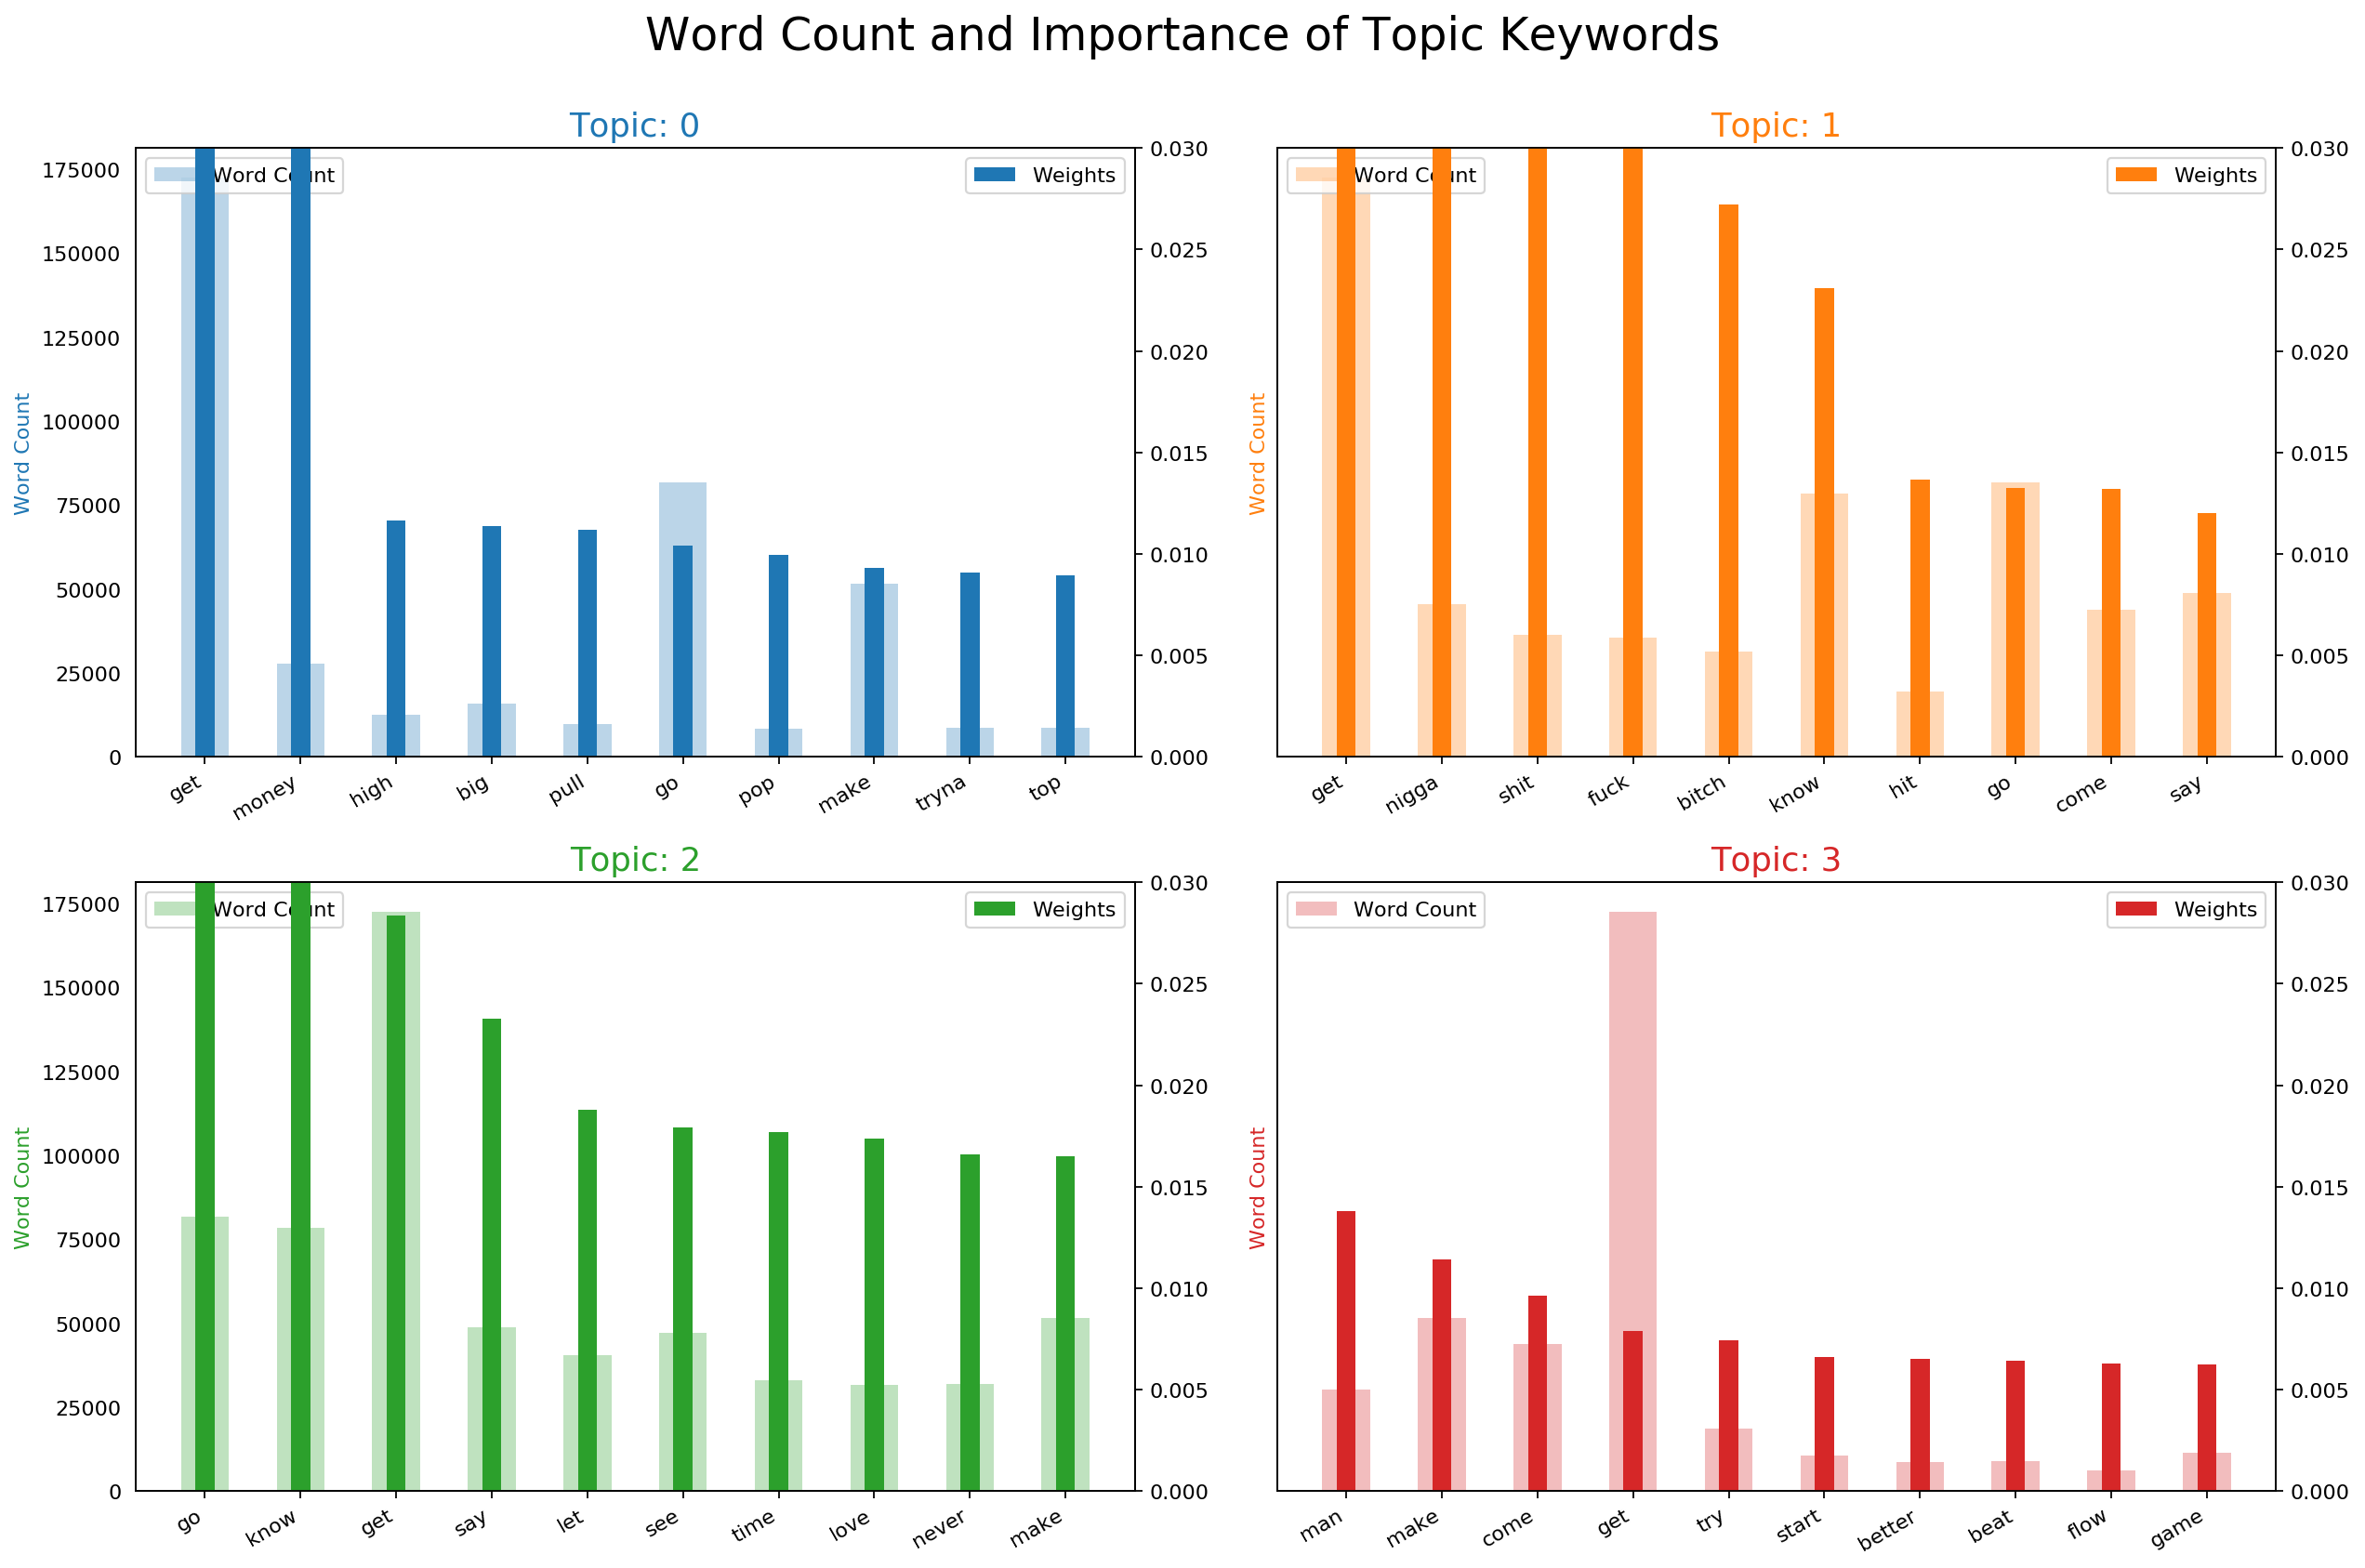

In [53]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030);
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Most discussed topic

In [56]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

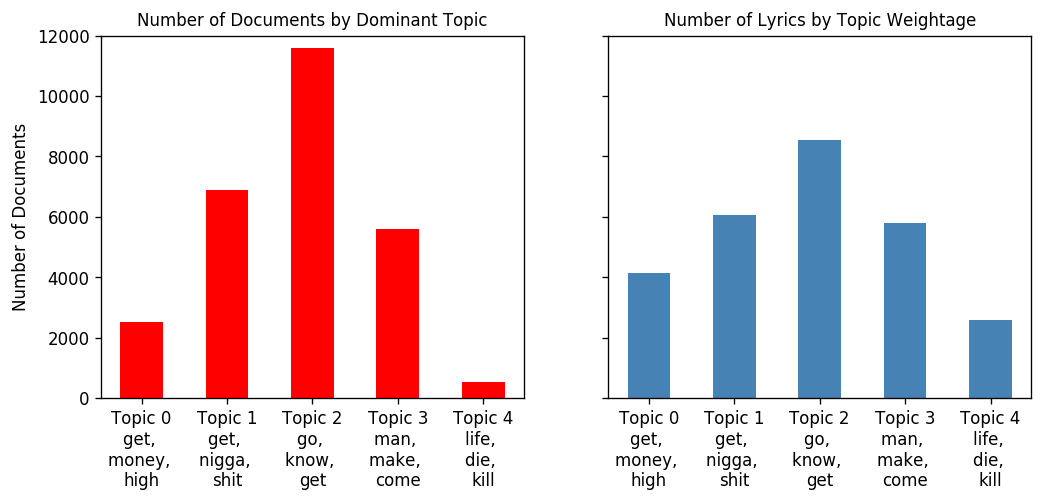

In [62]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='red')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 12000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Lyrics by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [64]:
df_dominant_topic.Dominant_Topic.value_counts()

2.0    11580
1.0     6890
3.0     5599
0.0     2503
4.0      537
Name: Dominant_Topic, dtype: int64

## t-SNE Clustering Chart

In [65]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20081 samples in 0.008s...
[t-SNE] Computed neighbors for 20081 samples in 0.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20081
[t-SNE] Computed conditional probabilities for sample 2000 / 20081
[t-SNE] Computed conditional probabilities for sample 3000 / 20081
[t-SNE] Computed conditional probabilities for sample 4000 / 20081
[t-SNE] Computed conditional probabilities for sample 5000 / 20081
[t-SNE] Computed conditional probabilities for sample 6000 / 20081
[t-SNE] Computed conditional probabilities for sample 7000 / 20081
[t-SNE] Computed conditional probabilities for sample 8000 / 20081
[t-SNE] Computed conditional probabilities for sample 9000 / 20081
[t-SNE] Computed conditional probabilities for sample 10000 / 20081
[t-SNE] Computed conditional probabilities for sample 11000 / 20081
[t-SNE] Computed conditional probabilities for sample 12000 / 20081
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis